# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, Imputer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

# magic word for producing visualizations in notebook
%matplotlib inline


'''
Import note: The classroom currently uses sklearn version 0.19.
If you need to use an imputer, it is available in sklearn.preprocessing.Imputer,
instead of sklearn.impute as in newer versions of sklearn.
'''

'\nImport note: The classroom currently uses sklearn version 0.19.\nIf you need to use an imputer, it is available in sklearn.preprocessing.Imputer,\ninstead of sklearn.impute as in newer versions of sklearn.\n'


### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [2]:
# Load in the general demographics data.
azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv', sep=';')

# Load in the feature summary file.
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', sep=';')

In [3]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).

azdias.shape

(891221, 85)

In [4]:
num_columns = feat_info.shape[1]
num_rows = feat_info.shape[0]

print("Number of rows in the Features Summary Dataframe:", num_rows)
print("Number of columns in the Features Summary Dataframe:", num_columns)


Number of rows in the Features Summary Dataframe: 85
Number of columns in the Features Summary Dataframe: 4


In [5]:
azdias.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2,4,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,-1,3,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


In [6]:
azdias.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891221 entries, 0 to 891220
Data columns (total 85 columns):
AGER_TYP                 891221 non-null int64
ALTERSKATEGORIE_GROB     891221 non-null int64
ANREDE_KZ                891221 non-null int64
CJT_GESAMTTYP            886367 non-null float64
FINANZ_MINIMALIST        891221 non-null int64
FINANZ_SPARER            891221 non-null int64
FINANZ_VORSORGER         891221 non-null int64
FINANZ_ANLEGER           891221 non-null int64
FINANZ_UNAUFFAELLIGER    891221 non-null int64
FINANZ_HAUSBAUER         891221 non-null int64
FINANZTYP                891221 non-null int64
GEBURTSJAHR              891221 non-null int64
GFK_URLAUBERTYP          886367 non-null float64
GREEN_AVANTGARDE         891221 non-null int64
HEALTH_TYP               891221 non-null int64
LP_LEBENSPHASE_FEIN      886367 non-null float64
LP_LEBENSPHASE_GROB      886367 non-null float64
LP_FAMILIE_FEIN          886367 non-null float64
LP_FAMILIE_GROB          886367 n

In [7]:
feat_info.head()

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]


In [8]:
feat_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85 entries, 0 to 84
Data columns (total 4 columns):
attribute             85 non-null object
information_level     85 non-null object
type                  85 non-null object
missing_or_unknown    85 non-null object
dtypes: object(4)
memory usage: 2.7+ KB


In [9]:
feat_info.describe

<bound method NDFrame.describe of                 attribute information_level         type missing_or_unknown
0                AGER_TYP            person  categorical             [-1,0]
1    ALTERSKATEGORIE_GROB            person      ordinal           [-1,0,9]
2               ANREDE_KZ            person  categorical             [-1,0]
3           CJT_GESAMTTYP            person  categorical                [0]
4       FINANZ_MINIMALIST            person      ordinal               [-1]
5           FINANZ_SPARER            person      ordinal               [-1]
6        FINANZ_VORSORGER            person      ordinal               [-1]
7          FINANZ_ANLEGER            person      ordinal               [-1]
8   FINANZ_UNAUFFAELLIGER            person      ordinal               [-1]
9        FINANZ_HAUSBAUER            person      ordinal               [-1]
10              FINANZTYP            person  categorical               [-1]
11            GEBURTSJAHR            person      numer

> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [10]:
print('{} total missing values'.format(azdias.isnull().sum().sum()))


4896838 total missing values


In [11]:
azdias.shape

(891221, 85)

Code below handles missing_or_unknown columns to correspond to the values,  ensures data types in list match in the azdias DF and checks for redundant or unnecessary values.

In [12]:
#Identify missing or unknown data values and convert them to NaNs.
#List values by each row in the missing_or_unknown column
for indx in range(len(feat_info)):
    missing_or_unknown = feat_info.iloc[indx]['missing_or_unknown']
    missing_or_unknown = missing_or_unknown.strip('[')
    missing_or_unknown = missing_or_unknown.strip(']')
    missing_or_unknown = missing_or_unknown.split(sep=',')
    missing_or_unknown = [int(value) if (value!='X' and value!='XX' and value!='') else value for value in missing_or_unknown]
    if missing_or_unknown != ['']:
        azdias = azdias.replace({feat_info.iloc[indx]['attribute']: missing_or_unknown}, np.nan)

In [13]:
print('{} total count of missing values post conversions.'.format(azdias.isnull().sum().sum()))


8373929 total count of missing values post conversions.


In [14]:
 azdias.describe

<bound method NDFrame.describe of         AGER_TYP  ALTERSKATEGORIE_GROB  ANREDE_KZ  CJT_GESAMTTYP  \
0            NaN                   2.0          1            2.0   
1            NaN                   1.0          2            5.0   
2            NaN                   3.0          2            3.0   
3            2.0                   4.0          2            2.0   
4            NaN                   3.0          1            5.0   
5            3.0                   1.0          2            2.0   
6            NaN                   2.0          2            5.0   
7            NaN                   1.0          1            3.0   
8            NaN                   3.0          1            3.0   
9            NaN                   3.0          2            4.0   
10           NaN                   3.0          2            1.0   
11           NaN                   2.0          1            6.0   
12           NaN                   3.0          1            6.0   
13           N

All missing values have been re-encoded with NaN.

#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

In [15]:
# Perform an assessment of how much missing data there is in each column of the
# dataset.

blank_values_by_column =(azdias.isnull().sum()/len(azdias))*100

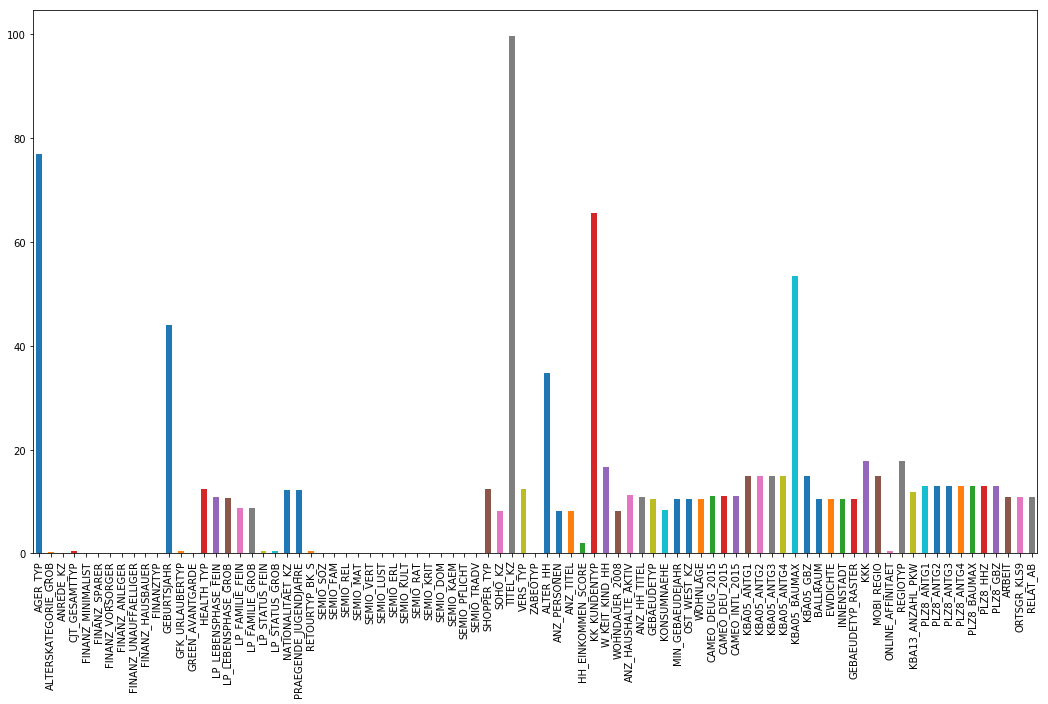

In [16]:
blank_values_by_column.plot.bar(figsize=(18, 10));

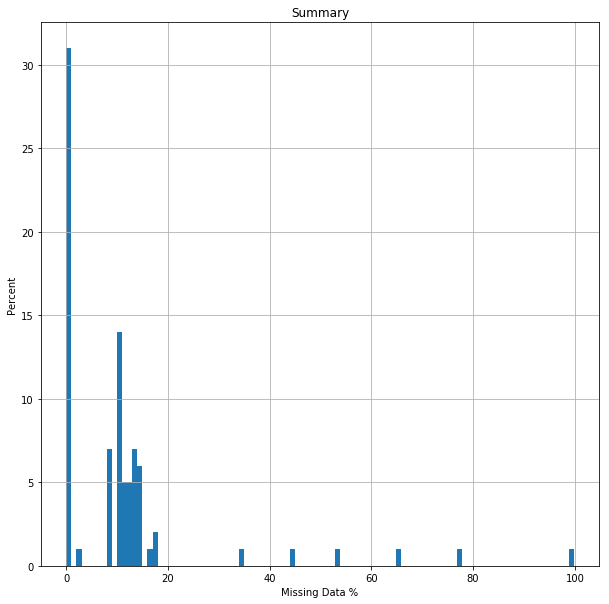

In [17]:
# Investigate patterns in the amount of missing data in each column.
plt.figure(figsize=(10, 10))
blank_values_by_column.sort_values(inplace=True)
plt.hist(blank_values_by_column, bins=100)
plt.xlabel('Missing Data %')
plt.ylabel('Percent')
plt.title('Summary')
plt.grid(True)
plt.show()

In [18]:
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)

#OLD Going by threshold of 0.02 or 2%
#OLD Extract column names with blank percentages less than the threshold
#OLD columns_to_remove = less_than_2_perct
#OLD Define columns to remove

#OLD Remove 'KK_KUNDENTYP' column from columns_to_remove along with any column from blank_pct_by_column with values below 2%
#OLD columns_to_remove = ['CJT_GESAMTTYP','GFK_URLAUBERTYP','LP_FAMILIE_FEIN','LP_FAMILIE_GROB','LP_LEBENSPHASE_FEIN','LP_LEBENSPHASE_GROB','LP_STATUS_FEIN','LP_STATUS_GROB','ONLINE_AFFINITAET','RETOURTYP_BK_S','PLZ8_ANTG1','PLZ8_ANTG2','PLZ8_ANTG3','PLZ8_ANTG4','PLZ8_BAUMAX','PLZ8_GBZ','PLZ8_HHZ','KKK','REGIOTYP','KBA05_ANTG1','KBA05_ANTG2','KBA05_ANTG3','KBA05_ANTG4','KBA05_BAUMAX','KBA05_GBZ','MOBI_REGIO','KK_KUNDENTYP']
#OLD Remove selected columns from the azdias dataframe
#OLD azdias_temp = azdias.drop(columns=columns_to_remove)
missing_column_15_perc = blank_values_by_column[blank_values_by_column>15]


drop_missing = missing_column_15_perc.index.tolist()
print('These are the columns that have more than 15% of missing values;')

for item in drop_missing:
    print(item)

These are the columns that have more than 15% of missing values;
W_KEIT_KIND_HH
KKK
REGIOTYP
ALTER_HH
GEBURTSJAHR
KBA05_BAUMAX
KK_KUNDENTYP
AGER_TYP
TITEL_KZ


In [19]:
azdias.shape

(891221, 85)

In [20]:
#Apply drop by columns
azdias = azdias.drop(drop_missing, axis=1)

In [21]:
azdias.shape

(891221, 76)

In [22]:
# Graph difference of null values with 15% or more in missing values in barchart

new_blank_values_by_column = azdias.isnull().sum()

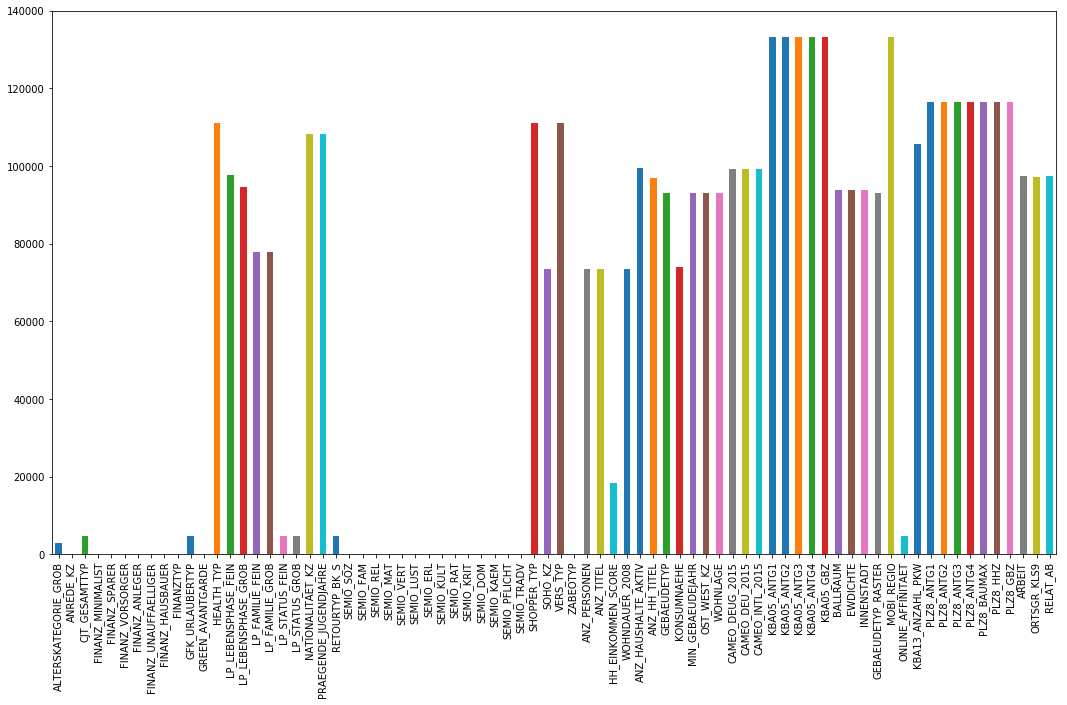

In [23]:
new_blank_values_by_column.plot.bar(figsize=(18, 10));

#### Discussion 1.1.2: Assess Missing Data in Each Column

Previously observed, outliers had about 800,000 rows of missing data. This is significantly different from the majority of other data points. Once we calcutaed the amount of missing values and filtered it to include only the columns with a relatively low percentage of missing values, we see the amount of missing rows was highets at 80,000. Therefore, we can be comfortable in removing the data.

#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

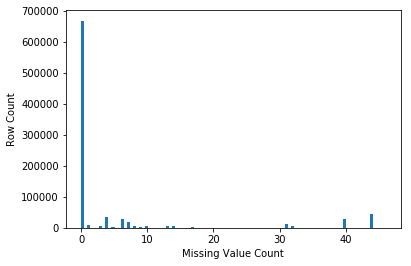

In [24]:
# How much data is missing in each row of the dataset?

missing_rows = azdias.isnull().sum(axis=1)
plt.hist(missing_rows, bins=100)
plt.ylabel('Row Count')
plt.xlabel('Missing Value Count')
plt.show()

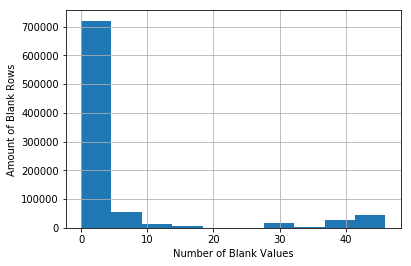

In [25]:
null_counts = azdias.isnull().sum(axis=1).sort_values(ascending=False)
hist = null_counts.hist()

# Set labels for the histogram

plt.xlabel('Number of Blank Values')
plt.ylabel('Amount of Blank Rows')

# Display the histogram
plt.show()

In [26]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.

group_1 = azdias[azdias.isnull().sum(axis=1) <= 3]
group_2 = azdias[azdias.isnull().sum(axis=1) >= 3]
print(group_1.shape)
print(group_2.shape)

(685120, 76)
(213018, 76)


In [27]:
group_1.isnull().sum()[group_1.isnull().sum()==0]

ALTERSKATEGORIE_GROB     0
ANREDE_KZ                0
CJT_GESAMTTYP            0
FINANZ_MINIMALIST        0
FINANZ_SPARER            0
FINANZ_VORSORGER         0
FINANZ_ANLEGER           0
FINANZ_UNAUFFAELLIGER    0
FINANZ_HAUSBAUER         0
FINANZTYP                0
GFK_URLAUBERTYP          0
GREEN_AVANTGARDE         0
HEALTH_TYP               0
LP_FAMILIE_FEIN          0
LP_FAMILIE_GROB          0
LP_STATUS_FEIN           0
LP_STATUS_GROB           0
NATIONALITAET_KZ         0
RETOURTYP_BK_S           0
SEMIO_SOZ                0
SEMIO_FAM                0
SEMIO_REL                0
SEMIO_MAT                0
SEMIO_VERT               0
SEMIO_LUST               0
SEMIO_ERL                0
SEMIO_KULT               0
SEMIO_RAT                0
SEMIO_KRIT               0
SEMIO_DOM                0
SEMIO_KAEM               0
SEMIO_PFLICHT            0
SEMIO_TRADV              0
SHOPPER_TYP              0
SOHO_KZ                  0
VERS_TYP                 0
ZABEOTYP                 0
A

In [28]:
group_2.isnull().sum()[group_2.isnull().sum()==0]

ANREDE_KZ                0
FINANZ_MINIMALIST        0
FINANZ_SPARER            0
FINANZ_VORSORGER         0
FINANZ_ANLEGER           0
FINANZ_UNAUFFAELLIGER    0
FINANZ_HAUSBAUER         0
FINANZTYP                0
GREEN_AVANTGARDE         0
SEMIO_SOZ                0
SEMIO_FAM                0
SEMIO_REL                0
SEMIO_MAT                0
SEMIO_VERT               0
SEMIO_LUST               0
SEMIO_ERL                0
SEMIO_KULT               0
SEMIO_RAT                0
SEMIO_KRIT               0
SEMIO_DOM                0
SEMIO_KAEM               0
SEMIO_PFLICHT            0
SEMIO_TRADV              0
ZABEOTYP                 0
dtype: int64

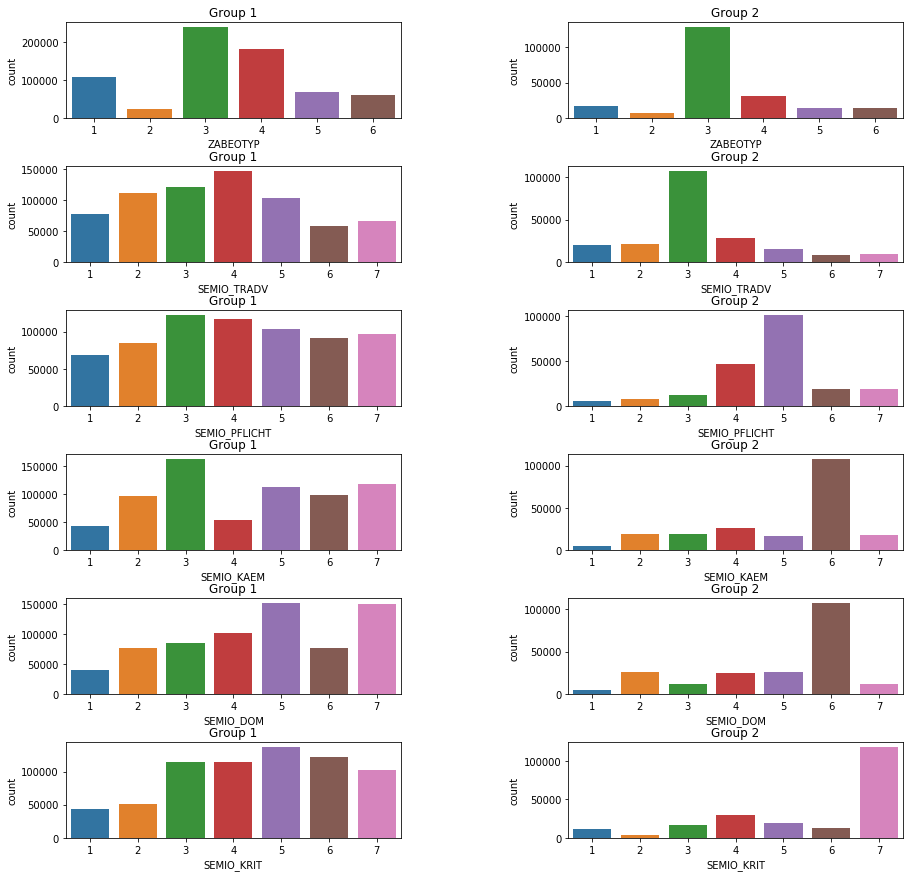

In [29]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.

no_missing_coloumns = blank_values_by_column[blank_values_by_column==0].index.tolist()
comparison = no_missing_coloumns[:6]
figure, axs = plt.subplots(nrows=len(comparison), ncols=2, figsize = (15,15))
figure.subplots_adjust(hspace = .5, wspace=.5)
for i in range(len(comparison)):
    sns.countplot(group_1[comparison[i]], ax=axs[i][0])
    axs[i][0].set_title('Group 1')
    sns.countplot(group_2[comparison[i]], ax=axs[i][1])
    axs[i][1].set_title('Group 2')

In [30]:
pct_pct_group_1 = group_1.shape[0] / azdias.shape[0] * 100
rounded_pct_pct_group_1 = round(pct_pct_group_1, 2)
print(rounded_pct_pct_group_1)

76.87


In [31]:
pct_pct_group_2 = group_2.shape[0] / azdias.shape[0] * 100
rounded_pct_pct_group_2 = round(pct_pct_group_2, 2)
print(rounded_pct_pct_group_2)

23.9


#### Discussion 1.1.3: Assess Missing Data in Each Row

The first histogram shows there are over 700,000 rows of missing values. This accounts for roughly 5% of the entire dataset. Further analysis required divding the dataset into two groups(1 and 2). Group 1 contained 76.87% of data while group 2 contained 23.9%. Group 1 is substantially better than group 2 and holds 52.97% more data. The subsequent 6 histograms also support my observation that group 1 is the better set to use.

### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [32]:
#How many features are there of each data type?
features = list(group_1.columns)
features_info = feat_info[feat_info['attribute'].isin(features)]
data_types = features_info['type'].value_counts()
feat_info.type.value_counts()

ordinal        49
categorical    21
numeric         7
mixed           7
interval        1
Name: type, dtype: int64

#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [33]:
#Split out binary and multiple features

categorical = features_info[features_info["type"] == "categorical"]["attribute"]
binary = []
multiple = []

for feature in categorical:
    if len(group_1[feature].unique()) == 2:
        binary.append(feature)
    elif len(group_1[feature].unique()) > 2:
        multiple.append(feature)

print('Binary features = {}'.format(binary))
print('Multiple features = {}'.format(multiple))

Binary features = ['ANREDE_KZ', 'GREEN_AVANTGARDE', 'SOHO_KZ', 'VERS_TYP', 'OST_WEST_KZ']
Multiple features = ['CJT_GESAMTTYP', 'FINANZTYP', 'GFK_URLAUBERTYP', 'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB', 'LP_STATUS_FEIN', 'LP_STATUS_GROB', 'NATIONALITAET_KZ', 'SHOPPER_TYP', 'ZABEOTYP', 'GEBAEUDETYP', 'CAMEO_DEUG_2015', 'CAMEO_DEU_2015']


In [34]:
for attribute in feat_info[feat_info['type']=='categorical'].attribute:
    if attribute in azdias.columns:
        if azdias[attribute].nunique() == 2:
            print('Unique Values:')
            print(attribute, azdias[attribute].unique())

Unique Values:
ANREDE_KZ [1 2]
Unique Values:
GREEN_AVANTGARDE [0 1]
Unique Values:
SOHO_KZ [ nan   1.   0.]
Unique Values:
VERS_TYP [ nan   2.   1.]
Unique Values:
OST_WEST_KZ [nan 'W' 'O']


In [35]:
#Re-encode categorical
replace_values = {'W': 0, 'O': 1}
azdias_final_1 = group_1.replace({'OST_WEST_KZ':replace_values})

#Drop features with multiple
for feature in multiple:
    azdias_final_1 = azdias_final_1.drop(feature, axis=1)

#### Discussion 1.2.1: Re-Encode Categorical Features

I first identified categorical types then removed mixed variable. The I organized the data by using the get_dummies feature on OST_WEST_KZ column since it was binary and non-numeric.



For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via OneHotEncoder), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

CAMEO: Wealth and Life stages with international cod
    11: Wealthy Households - Pre-Family Couples & Singles
    12: Wealthy Households - Young Couples With Children
    13: Wealthy Households - Families With School Age Children
    14: Wealthy Households - Older Families & Mature Couples
    15: Wealthy Households - Elders In Retirement
    21: Prosperous Households - Pre-Family Couples & Singles
    22: Prosperous Households - Young Couples With Children
    23: Prosperous Households - Families With School Age Children
    24: Prosperous Households - Older Families & Mature Couples
    25: Prosperous Households - Elders In Retirement
    31: Comfortable Households - Pre-Family Couples & Singles
    32: Comfortable Households - Young Couples With Children
    33: Comfortable Households - Families With School Age Children
    34: Comfortable Households - Older Families & Mature Couples
    35: Comfortable Households - Elders In Retirement
    41: Less Affluent Households - Pre-Family Couples & Singles
    42: Less Affluent Households - Young Couples With Children
    43: Less Affluent Households - Families With School Age Children
    44: Less Affluent Households - Older Families & Mature Couples
    45: Less Affluent Households - Elders In Retirement
    51: Poorer Households - Pre-Family Couples & Singles
    52: Poorer Households - Young Couples With Children
    53: Poorer Households - Families With School Age Children
    54: Poorer Households - Older Families & Mature Couples
    55: Poorer Households - Elders In Retirement

In [36]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.

azdias_final_1['DECADE'] = azdias_final_1['PRAEGENDE_JUGENDJAHRE']
azdias_final_1['MOVEMENT'] = azdias_final_1['PRAEGENDE_JUGENDJAHRE']

In [37]:
#Create dictionaries for both dimensions in "PRAEGENDE_JUGENDJAHRE"

decade = {1:1, 2:1, 3:2, 4:2, 5:3, 6:3, 7:3, 8:4, 9:4, 10:5, 11:5, 12:5, 13:5, 14:6, 15:6}
movement = {1:1, 2:0, 3:1, 4:0, 5:1, 6:0, 7:0, 8:1, 9:0, 10:1, 11:0, 12:1, 13:0, 14:1, 15:0}

In [38]:
azdias_final_1['DECADE'].replace(decade, inplace=True)
azdias_final_1['MOVEMENT'].replace(movement, inplace=True)

In [39]:
# Investigate "CAMEO_INTL_2015" and create 2 new variables

azdias_final_1['WEALTH'] = azdias_final_1['CAMEO_INTL_2015']
azdias_final_1['LIFE_STAGE'] = azdias_final_1['CAMEO_INTL_2015']

In [40]:
#Create dictionaries to Break up the two-digit codes by their 'tens'
#place and 'ones'-place digits into two new ordinal variables

wealth = {'11':1, '12':1, '13':1, '14':1, '15':1, '21':2, '22':2, '23':2, '24':2, '25':2,
               '31':3, '32':3, '33':3, '34':3, '35':3, '41':4, '42':4, '43':4, '44':4, '45':4,
               '51':5, '52':5, '53':5, '54':5, '55':5}

lifestage = {'11':1, '12':2, '13':3, '14':4, '15':5, '21':1, '22':2, '23':3, '24':4, '25':5,
                   '31':1, '32':2, '33':3, '34':4, '35':5, '41':1, '42':2, '43':3, '44':4, '45':5,
                   '51':1, '52':2, '53':3, '54':4, '55':5}

azdias_final_1['WEALTH'].replace(wealth, inplace=True)
azdias_final_1['LIFE_STAGE'].replace(lifestage, inplace=True)

In [41]:
azdias_final_1

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,DECADE,MOVEMENT,WEALTH,LIFE_STAGE
1,1.0,2,1,5,2,5,4,5,0,3.0,...,1.0,5.0,4.0,3.0,5.0,4.0,6.0,1.0,5.0,1.0
2,3.0,2,1,4,1,2,3,5,1,3.0,...,1.0,4.0,4.0,3.0,5.0,2.0,6.0,0.0,2.0,4.0
4,3.0,1,4,3,4,1,3,2,0,3.0,...,2.0,3.0,3.0,4.0,6.0,5.0,4.0,1.0,4.0,3.0
5,1.0,2,3,1,5,2,2,5,0,3.0,...,1.0,5.0,5.0,2.0,3.0,3.0,2.0,1.0,5.0,4.0
6,2.0,2,1,5,1,5,4,3,0,2.0,...,1.0,5.0,5.0,4.0,6.0,3.0,5.0,1.0,2.0,2.0
7,1.0,1,3,3,4,1,3,2,0,1.0,...,1.0,4.0,4.0,2.0,5.0,2.0,4.0,1.0,1.0,4.0
8,3.0,1,4,4,2,4,2,2,1,3.0,...,1.0,3.0,3.0,2.0,4.0,3.0,5.0,0.0,1.0,3.0
9,3.0,2,2,4,2,3,5,4,1,2.0,...,1.0,3.0,3.0,2.0,3.0,1.0,6.0,0.0,1.0,5.0
10,3.0,2,2,2,5,3,1,5,0,2.0,...,2.0,3.0,3.0,4.0,6.0,5.0,2.0,1.0,5.0,1.0
18,2.0,2,2,4,1,5,4,1,0,2.0,...,1.0,3.0,3.0,3.0,4.0,3.0,5.0,1.0,2.0,4.0


#### Discussion 1.2.2: Engineer Mixed-Type Features


There are many features that are mixed variables and require investigation prior to being included in the analysis. Two that I focused on were "PRAEGENDE_JUGENDJAHRE" and  "CAMEO_INTL_2015".

"PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.

"CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).


#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [42]:
# If there are other re-engineering tasks you need to perform, make sure you
# take care of them here. (Dealing with missing data will come in step 2.1.)

#Nothing done in this section

In [43]:
# Do whatever you need to in order to ensure that the dataframe only contains
# the columns that should be passed to the algorithm functions.

multiple_features = features_info[features_info["type"]=="mixed"]["attribute"]
for feature in multiple_features:
    azdias_final_1.drop(feature, axis=1, inplace=True)  


In [44]:
azdias_final_1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 685120 entries, 1 to 891220
Data columns (total 61 columns):
ALTERSKATEGORIE_GROB     685120 non-null float64
ANREDE_KZ                685120 non-null int64
FINANZ_MINIMALIST        685120 non-null int64
FINANZ_SPARER            685120 non-null int64
FINANZ_VORSORGER         685120 non-null int64
FINANZ_ANLEGER           685120 non-null int64
FINANZ_UNAUFFAELLIGER    685120 non-null int64
FINANZ_HAUSBAUER         685120 non-null int64
GREEN_AVANTGARDE         685120 non-null int64
HEALTH_TYP               685120 non-null float64
RETOURTYP_BK_S           685120 non-null float64
SEMIO_SOZ                685120 non-null int64
SEMIO_FAM                685120 non-null int64
SEMIO_REL                685120 non-null int64
SEMIO_MAT                685120 non-null int64
SEMIO_VERT               685120 non-null int64
SEMIO_LUST               685120 non-null int64
SEMIO_ERL                685120 non-null int64
SEMIO_KULT               685120 non-n

### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [45]:
def clean_data(df):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    
    # Put in code here to execute all main cleaning steps:
    # convert missing value codes into NaNs, ...
    
    for indx in range(len(feat_info)):
        missing_or_unknown = feat_info.iloc[indx]['missing_or_unknown']
        missing_or_unknown = missing_or_unknown.strip('[')
        missing_or_unknown = missing_or_unknown.strip(']')
        missing_or_unknown = missing_or_unknown.split(sep=',')
        missing_or_unknown = [int(value) if (value!='X' and value!='XX' and value!='') else value for value in missing_or_unknown]
        if missing_or_unknown != ['']:
            df_final = df.replace({feat_info.iloc[indx]['attribute']: missing_or_unknown}, np.nan)
    
    for col in df.columns:
        df_final = df_final.replace({col: ['XX', 'X']}, np.nan)
        
    #Drop columns with more than 15% blanks    
    drop_missing = ['W_KEIT_KIND_HH', 'KKK', 'REGIOTYP', 'ALTER_HH', 'GEBURTSJAHR' ,'KBA05_BAUMAX', 'KK_KUNDENTYP', 'AGER_TYP' , 'TITEL_KZ']    
    df_final = df_final.drop(drop_missing, axis=1)
        
    #Drop columns with multi-level features 
    drop_multiples = ['CJT_GESAMTTYP', 'FINANZTYP', 'GFK_URLAUBERTYP', 'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB', 'LP_STATUS_FEIN', 'LP_STATUS_GROB', 'NATIONALITAET_KZ', 'SHOPPER_TYP', 'ZABEOTYP', 'GEBAEUDETYP', 'CAMEO_DEUG_2015', 'CAMEO_DEU_2015']
    df_final = df_final.drop(drop_multiples, axis=1)
                     
    #Convert binary
    replace_values = {'W': 0, 'O': 1}
    df_final = df_final.replace({'OST_WEST_KZ':replace_values})
        
     
    # engineer mixed features
    df_final['DECADE'] = df_final['PRAEGENDE_JUGENDJAHRE']
    df_final['MOVEMENT'] = df_final['PRAEGENDE_JUGENDJAHRE']

    
    decade = {1:1, 2:1, 3:2, 4:2, 5:3, 6:3, 7:3, 8:4, 9:4, 10:5, 11:5, 12:5, 13:5, 14:6, 15:6}
    movement = {1:1, 2:0, 3:1, 4:0, 5:1, 6:0, 7:0, 8:1, 9:0, 10:1, 11:0, 12:1, 13:0, 14:1, 15:0}
    
    df_final['DECADE'].replace(decade, inplace=True)
    df_final['MOVEMENT'].replace(movement, inplace=True)
    
    df_final['WEALTH'] = df_final['CAMEO_INTL_2015']
    df_final['LIFE_STAGE'] = df_final['CAMEO_INTL_2015']
    
    wealth = {'11':1, '12':1, '13':1, '14':1, '15':1, '21':2, '22':2, '23':2, '24':2, '25':2,
               '31':3, '32':3, '33':3, '34':3, '35':3, '41':4, '42':4, '43':4, '44':4, '45':4,
               '51':5, '52':5, '53':5, '54':5, '55':5}
    
    lifestage = {'11':1, '12':2, '13':3, '14':4, '15':5, '21':1, '22':2, '23':3, '24':4, '25':5,
                   '31':1, '32':2, '33':3, '34':4, '35':5, '41':1, '42':2, '43':3, '44':4, '45':5,
                   '51':1, '52':2, '53':3, '54':4, '55':5}
        
           
    # Return the cleaned dataframe.
    return df_final
    

## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](https://scikit-learn.org/0.16/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [46]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and
# do that now.

azdias_final_1.isna().any().values

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False,  True,  True,  True, False, False,
       False, False, False, False, False,  True,  True,  True,  True,
       False, False,  True, False, False, False, False, False, False,
        True,  True,  True,  True,  True,  True,  True], dtype=bool)

In [47]:
impute_missing = Imputer(strategy='mean')
azdias_imputed = pd.DataFrame(impute_missing.fit_transform(azdias_final_1))

In [48]:
azdias_imputed.columns = azdias_final_1.columns
azdias_imputed.index = azdias_final_1.index

In [49]:
# Apply feature scaling to the general population demographics data.
standard_scaler = StandardScaler() 
azdias_scaled = standard_scaler.fit_transform(azdias_imputed)
azdias_scaled = pd.DataFrame(azdias_scaled, columns=list(azdias_imputed))


In [50]:
azdias_scaled.isna().any().values

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False], dtype=bool)

All values show false now for na, blank, missing values.

In [51]:
azdias_scaled.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,PLZ8_ANTG4,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,DECADE,MOVEMENT,WEALTH,LIFE_STAGE
0,-1.747637,0.975450,-1.523872,1.588937,-1.050075,1.512817,1.048637,1.341477,-0.542867,1.038695,...,0.409547,1.432045,0.564598,-0.184152,-0.134134,0.678900,1.163882,0.549133,1.177870,-1.264695
1,0.193533,0.975450,-1.523872,0.908508,-1.771276,-0.549154,0.320682,1.341477,1.842073,1.038695,...,-0.963552,0.402680,0.564598,-0.184152,-0.134134,-0.799274,1.163882,-1.839344,-0.870773,0.751039
2,0.193533,-1.025168,0.677265,0.228079,0.392328,-1.236477,0.320682,-0.834382,-0.542867,1.038695,...,0.409547,-0.626685,-0.335099,0.822570,0.301691,1.417987,-0.222807,0.549133,0.494989,0.079128
3,-1.747637,0.975450,-0.056447,-1.132778,1.113529,-0.549154,-0.407273,1.341477,-0.542867,1.038695,...,0.409547,1.432045,1.464295,-1.190874,-1.005785,-0.060187,-1.609496,0.549133,1.177870,0.751039
4,-0.777052,0.975450,-1.523872,1.588937,-1.771276,1.512817,1.048637,-0.109096,-0.542867,-0.285986,...,-0.963552,1.432045,1.464295,0.822570,0.301691,-0.060187,0.470537,0.549133,-0.870773,-0.592783


### Discussion 2.1: Apply Feature Scaling

For the remaining missing values in my dataset, I used the mean imputation for each column. Additionally, I applied the StandardScaler to scale my features. The StandardScaler normalizes each feature by centering it around a mean of 0 and scaling it with a standard deviation of 1.

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [52]:
# Apply PCA to the data.

pca_1 = PCA()
model = pca_1.fit_transform(azdias_scaled)

In [53]:
# Investigate the variance accounted for by each principal component.

def scree_plot(pca):

    num_components = len(pca.explained_variance_ratio_)
    ind = np.arange(num_components)
    vals = pca.explained_variance_ratio_
 
    plt.figure(figsize=(10, 6))
    ax = plt.subplot(111)
    cumvals = np.cumsum(vals)
    ax.bar(ind, vals)
    ax.plot(ind, cumvals)
    
    ax.xaxis.set_tick_params(width=0)
    ax.yaxis.set_tick_params(width=2, length=12)
 
    ax.set_xlabel("Principal Component")
    ax.set_ylabel("Variance Explained (%)")
    plt.title('Explained Variance Per Principal Component')


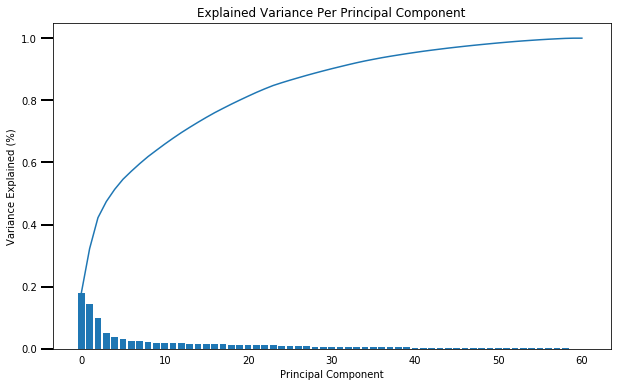

In [54]:
scree_plot(pca_1)

In [55]:
for i in np.arange(15, len(pca_1.explained_variance_ratio_), 15):
    print('For {} components, explained variance:'.format(i), 
          pca_1.explained_variance_ratio_[:i].sum())

For 15 components, explained variance: 0.729428677971
For 30 components, explained variance: 0.894643978654
For 45 components, explained variance: 0.968094270049
For 60 components, explained variance: 0.999978630802


In [56]:
# Re-apply PCA to the data while selecting for number of components to retain.

pca_15 = PCA(n_components=15)
azdias_pca = pca_15.fit_transform(azdias_scaled)

In [57]:
pca_15.explained_variance_ratio_.sum()

0.72931094543797259

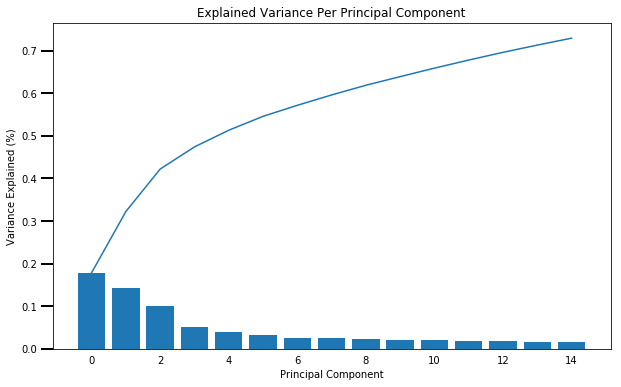

In [58]:
scree_plot(pca_15)

### Discussion 2.2: Perform Dimensionality Reduction

After understanding the concept of explained variance through principal components, we observed that the first component accounts for approximately 99% of the total variability in the data. By including 15 components, we can capture as much as 73% of the overall variability. Therefore, I retained these 30 components for the next stage. While it's possible to choose more components, opting for 14 strikes a good balance as it explains a significant portion of the total variability. Even so both performed rather well, after re-applying PCA, we notice a difference in the hundred-thousandths place.

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [59]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.

def pca_results(pca, i):
    df = pd.DataFrame(pca.components_, columns=list(azdias_scaled.columns))
    weights = df.iloc[i].sort_values(ascending=False)
    return weights

In [60]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.

pca_results_1 = pca_results(pca_15, 0)
print (pca_results_1)

PLZ8_ANTG3               0.219919
PLZ8_ANTG4               0.213377
WEALTH                   0.199952
HH_EINKOMMEN_SCORE       0.197151
ORTSGR_KLS9              0.190443
EWDICHTE                 0.188439
FINANZ_SPARER            0.159876
FINANZ_HAUSBAUER         0.151063
KBA05_ANTG4              0.149290
PLZ8_ANTG2               0.148695
ARBEIT                   0.138451
KBA05_ANTG3              0.134414
ANZ_HAUSHALTE_AKTIV      0.133266
RELAT_AB                 0.129072
SEMIO_PFLICHT            0.126741
SEMIO_REL                0.124829
DECADE                   0.121090
SEMIO_TRADV              0.111599
MOVEMENT                 0.107769
SEMIO_RAT                0.106349
SEMIO_MAT                0.093761
FINANZ_UNAUFFAELLIGER    0.090445
SEMIO_FAM                0.089449
SEMIO_KULT               0.085433
FINANZ_ANLEGER           0.076463
OST_WEST_KZ              0.055573
SEMIO_SOZ                0.051127
PLZ8_HHZ                 0.041452
ANZ_HH_TITEL             0.032898
HEALTH_TYP    

In [61]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.

pca_results_2 = pca_results(pca_15, 1)
print (pca_results_2)

ALTERSKATEGORIE_GROB     0.249790
SEMIO_ERL                0.231039
FINANZ_VORSORGER         0.217603
SEMIO_LUST               0.173881
RETOURTYP_BK_S           0.161084
FINANZ_HAUSBAUER         0.127647
SEMIO_KRIT               0.125373
SEMIO_KAEM               0.121469
PLZ8_ANTG3               0.111662
PLZ8_ANTG4               0.107160
EWDICHTE                 0.106714
ORTSGR_KLS9              0.105634
ANREDE_KZ                0.098079
WEALTH                   0.088595
KBA05_ANTG4              0.082131
ARBEIT                   0.077650
SEMIO_DOM                0.076400
PLZ8_ANTG2               0.075634
RELAT_AB                 0.074538
ANZ_HAUSHALTE_AKTIV      0.071881
HH_EINKOMMEN_SCORE       0.067833
KBA05_ANTG3              0.056813
WOHNDAUER_2008           0.054300
FINANZ_MINIMALIST        0.045392
ANZ_HH_TITEL             0.033159
VERS_TYP                 0.031642
OST_WEST_KZ              0.031392
MOVEMENT                 0.021952
PLZ8_HHZ                 0.016843
ANZ_TITEL     

In [62]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.

pca_results_3 = pca_results(pca_15, 2)
print (pca_results_3)

SEMIO_VERT               0.347450
SEMIO_SOZ                0.261710
SEMIO_FAM                0.246449
SEMIO_KULT               0.227630
FINANZ_MINIMALIST        0.160451
RETOURTYP_BK_S           0.121888
FINANZ_VORSORGER         0.105676
ALTERSKATEGORIE_GROB     0.091840
SEMIO_LUST               0.079108
SEMIO_REL                0.071990
ORTSGR_KLS9              0.051794
EWDICHTE                 0.051672
PLZ8_ANTG4               0.049468
GREEN_AVANTGARDE         0.049415
PLZ8_ANTG3               0.048772
SEMIO_MAT                0.047079
WOHNDAUER_2008           0.039077
ARBEIT                   0.035743
RELAT_AB                 0.034326
PLZ8_ANTG2               0.032510
KBA05_ANTG4              0.031307
ANZ_HAUSHALTE_AKTIV      0.028475
WEALTH                   0.028460
VERS_TYP                 0.023085
ANZ_HH_TITEL             0.015041
OST_WEST_KZ              0.012894
ANZ_TITEL                0.010757
KBA05_ANTG3              0.008752
PLZ8_HHZ                 0.005732
ANZ_PERSONEN  

### Discussion 2.3: Interpret Principal Components

First Principal Component

Three Positives:
PRAEGENDE_JUGENDJAHRE_MOVEMENT       0.0019	dominant movement of the person's youth
PRAEGENDE_JUGENDJAHRE_GENERATIONS    0.0015	generation or era a person belongs to based on their dominant movement during their youth
ANZ_HAUSHALTE_AKTIV                  0.0010	number of households in the building or neighborhood where an individual resides

Three Negatives:
ALTER_HH                            -0.0043	age of head of household
KBA13_ANZAHL_PKW                    -0.0096	amount of registered passanger cars (PKW) in the building or neighborhood
GEBURTSJAHR                         -0.9999	the birth year

There is a positive correlation between a person's movement during their youth and the number of households where a person lives.
There is a negative correlation between the age of the head of household and amount of PKW in the neighborhood.



Second Principal Component

Three Positives:
KBA13_ANZAHL_PKW       0.9999			the number of registered passenger cars (PKW) in a specific region or area
LP_LEBENSPHASE_FEIN    0.0029			the current life stage or phase of the target population.
KBA05_ANTG1            0.0017			the number of buildings with 1-2 units in the microcell where an individual resides

Three Negatives:
PLZ8_BAUMAX           -0.0035			the maximum number of buildings in the PLZ8 region
ANZ_HAUSHALTE_AKTIV   -0.0038			the number of active households in a building or neighborhood
GEBURTSJAHR           -0.0096			the birth year

There is a positive correlation between registered cars, lifestage, and 1-2 unit buildings.
There is a negative correlation between maximum amount of buildings, active households in a neighborhood, and the birth year.



Third Principal Component

Three Positives:
KBA05_ANTG4            0.3325			the number of buildings in the microcell region with more than 10 units
KBA05_ANTG3            0.3311			the number of buildings in the microcell or small cell structure within the building's surrounding area
KBA05_ANTG2            0.3285			the number of 2-3 family houses in the microcell area. 

Three Negatives:
HH_EINKOMMEN_SCORE    -0.0062			the estimated income level of households
FINANZ_HAUSBAUER      -0.0071			the financial typology of individuals regarding their inclination towards home ownership
ANZ_HAUSHALTE_AKTIV   -0.0263			the number of active households in a building or neighborhood

There is a positive correlation between the number buildings with more than 10 units and number of 2-3 family houses in the area.
There is a negative correlation between the estimated income, liklihood of owning property and the number of active households.

## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [63]:
# Over a number of different cluster counts...

n_clusters = np.arange(1, 15)
distances = []

for n_cluster in n_clusters:
    # run k-means clustering on the data and...
    kmeans = KMeans(n_clusters=n_cluster)
    print('Fitting k = {} '.format(n_cluster))
    model = kmeans.fit_predict(azdias_pca)
    pred_centroids = kmeans.cluster_centers_
    centers = pred_centroids[model]
    # compute the average within-cluster distances.
    distance = np.sqrt(((azdias_pca - centers) ** 2).sum(axis = 1)).mean()
    distances.append(distance)

Fitting k = 1 
Fitting k = 2 
Fitting k = 3 
Fitting k = 4 
Fitting k = 5 
Fitting k = 6 
Fitting k = 7 
Fitting k = 8 
Fitting k = 9 
Fitting k = 10 
Fitting k = 11 
Fitting k = 12 
Fitting k = 13 
Fitting k = 14 


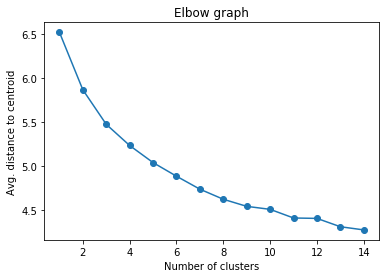

In [64]:
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.

plt.plot(n_clusters, distances, '-o')
plt.ylabel('Avg. distance to centroid')
plt.xlabel('Number of clusters')
plt.title('Elbow graph');

In [65]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.

kmeans = KMeans(n_clusters=4)
general_model = kmeans.fit(azdias_pca)

### Discussion 3.1: Apply Clustering to General Population

How I proceeded with deciding the amount of clusters was by using the elbow method, which is technique used to determine the optimal number of clusters in a dataset while using algorithms like k-means. K means compares the average distance of the center of the clusters and by anylizing the graph, I was able to narrow it down to four clusters. I did come across some porgamming challnges as the time K means takes a large amount of time.

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [66]:
# Load in the customer demographics data.

customers = pd.read_csv("Udacity_CUSTOMERS_Subset.csv", delimiter=";")
customers.shape

(191652, 85)

In [67]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.

customers_final = clean_data(customers)

In [68]:
customers_final.isnull().sum()

ALTERSKATEGORIE_GROB         0
ANREDE_KZ                    0
FINANZ_MINIMALIST            0
FINANZ_SPARER                0
FINANZ_VORSORGER             0
FINANZ_ANLEGER               0
FINANZ_UNAUFFAELLIGER        0
FINANZ_HAUSBAUER             0
GREEN_AVANTGARDE             0
HEALTH_TYP                   0
LP_LEBENSPHASE_FEIN       3213
LP_LEBENSPHASE_GROB       3213
PRAEGENDE_JUGENDJAHRE        0
RETOURTYP_BK_S            3213
SEMIO_SOZ                    0
SEMIO_FAM                    0
SEMIO_REL                    0
SEMIO_MAT                    0
SEMIO_VERT                   0
SEMIO_LUST                   0
SEMIO_ERL                    0
SEMIO_KULT                   0
SEMIO_RAT                    0
SEMIO_KRIT                   0
SEMIO_DOM                    0
SEMIO_KAEM                   0
SEMIO_PFLICHT                0
SEMIO_TRADV                  0
SOHO_KZ                  46596
VERS_TYP                     0
                         ...  
MIN_GEBAEUDEJAHR         49927
OST_WEST

In [69]:
customers_imputer = Imputer(strategy='mean')

In [70]:
customers_final_imputed = pd.DataFrame(customers_imputer.fit_transform(customers_final))

In [71]:
#OLD customers_imputed = pd.DataFrame(impute_missing.fit_transform(customers_final), columns=customers_final.keys())

In [72]:
customers_final_imputed.isna().any().values

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False], dtype=bool)

In [73]:
#MAY NOT NEED
customers_final_imputed.columns = customers_final.columns
customers_final_imputed.index = customers_final.index

In [74]:
customers_final_imputed.head()


,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,DECADE,MOVEMENT,WEALTH,LIFE_STAGE
0,4.0,1.0,5.0,1.0,5.0,1.0,2.0,2.0,1.0,1.0,...,1.000000,5.000000,5.000000,1.00000,2.000000,1.000000,2.0,0.0,13.000000,13.000000
1,4.0,1.0,5.0,1.0,5.0,1.0,3.0,2.0,0.0,1.0,...,1.556607,3.634893,3.622192,2.82485,5.119517,2.897515,0.0,0.0,29.355781,29.355781
2,4.0,2.0,5.0,1.0,5.0,1.0,4.0,4.0,1.0,2.0,...,3.000000,3.000000,2.000000,3.00000,5.000000,3.000000,2.0,0.0,34.000000,34.000000
3,4.0,1.0,5.0,1.0,5.0,2.0,1.0,2.0,0.0,2.0,...,1.000000,3.000000,4.000000,1.00000,3.000000,1.000000,1.0,1.0,24.000000,24.000000
4,3.0,1.0,3.0,1.0,4.0,4.0,5.0,2.0,0.0,3.0,...,2.000000,3.000000,3.000000,3.00000,5.000000,1.000000,4.0,1.0,41.000000,41.000000


In [75]:
customers_final_imputed_drop = ['CAMEO_INTL_2015', 'LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB', 'PLZ8_BAUMAX', 'PRAEGENDE_JUGENDJAHRE', 'WOHNLAGE']

# Drop the specified columns from the DataFrame
customers_final_imputed.drop(columns = customers_final_imputed_drop, inplace=True)
customers_final_imputed.shape

(191652, 61)

In [76]:
customers_final_imputed_copy = customers_final_imputed.copy()
customers_final_imputed_copy.to_csv('customers_final_imputed_copy.csv', index=False)

In [77]:
azdias_scaled.shape

(685120, 61)

In [78]:
#Scale data

customers_scaled = standard_scaler.transform(customers_final_imputed)
customers_scaled = pd.DataFrame(customers_scaled, columns = customers_final_imputed.columns)
customers_pca = pca_15.transform(customers_scaled)

In [79]:
#Prediction using general model Kmeans

prediction = general_model.predict(customers_pca)




### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

In [80]:
customers_cleaned = clean_data(customers)

Text(0.5,1,'General Population Prediction')

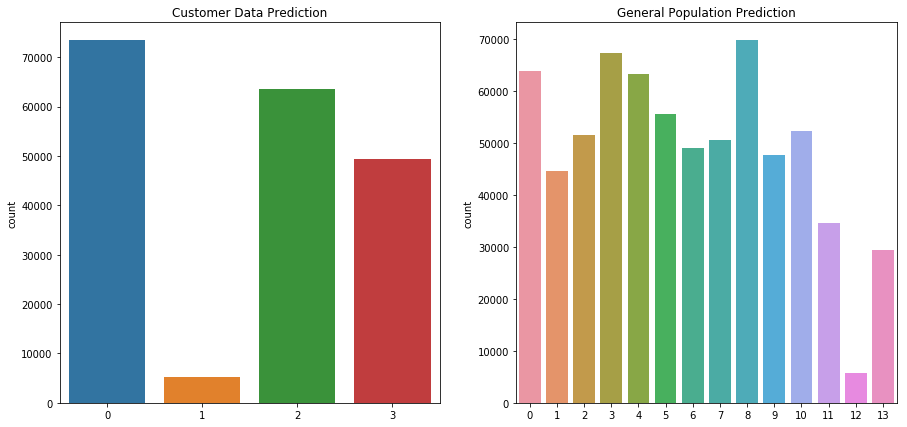

In [81]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.

figure, axs = plt.subplots(nrows=1, ncols=2, figsize = (15,7))
sns.countplot(prediction, ax=axs[0]) 
axs[0].set_title('Customer Data Prediction')
sns.countplot(model, ax=axs[1])
axs[1].set_title('General Population Prediction')

In [82]:
kmeans_1 = KMeans(n_clusters=15)
kmeans_1.fit(customers_scaled)

cluster_centers = kmeans_1.cluster_centers_
cluster_5_center = cluster_centers[5]

#Inverse transformations
baseline = standard_scaler.inverse_transform(pca_15.inverse_transform([cluster_5_center]))

ValueError: shapes (1,61) and (15,61) not aligned: 61 (dim 1) != 15 (dim 0)

In [ ]:
overrepresented_customers = pd.Series(data = centroid_10, index = customers.columns)
overrepresented_customers

prediction = general_model.predict(customers_pca)

In [ ]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?

underrepresented_customers = pd.Series(data = centroid_13, index = customers.columns)
underrepresented_customers

### Discussion 3.3: Compare Customer Data to Demographics Data

(Double-click this cell and replace this text with your own text, reporting findings and conclusions from the clustering analysis. Can we describe segments of the population that are relatively popular with the mail-order company, or relatively unpopular with the company?)

> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.